In [1]:
import nest_asyncio
import os
import joblib
import shutil
from dotenv import load_dotenv

nest_asyncio.apply()

In [2]:
# import chromadb
from langchain_chroma import Chroma
from llama_parse import LlamaParse
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA

In [3]:
load_dotenv(override=True)

os.environ['HF_HOME'] = './.cache/huggingface'
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'
CHROMA_PATH = "chroma"
parsed_path = "data\\parsed\\"
not_parsed_path = "data\\not parsed\\"

llama_api_key = os.getenv("LLAMAPARSE_API_KEY")
groq_api_key = os.getenv("CHATGROQ_API_KEY")
openai_api_key = os.getenv("OPENAI_API_KEY")

In [4]:
def db_connection(embedding_model_name, path):
    embedding = HuggingFaceEmbeddings(model_name=embedding_model_name) # C:\Users\Ruslan\.cache\huggingface\hub\models--uaritm--multilingual_en_ru_uk.
    
    # uaritm/multilingual_en_ru_uk
    # sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
    # sentence-transformers/paraphrase-multilingual-mpnet-base-v2
    # intfloat/multilingual-e5-large-instruct || intfloat/multilingual-e5-large
    
    db = Chroma(
        persist_directory=path, # Local mode with in-memory storage only
        embedding_function=embedding,
        collection_name="rag")
    return embedding, db
embedding, db = db_connection("uaritm/multilingual_en_ru_uk", CHROMA_PATH)

In [16]:
def split_documents():
    loader = DirectoryLoader(f"{parsed_path}", glob="**/*.md", show_progress=True)
    documents = loader.load()

    # Split loaded documents into chunks
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)
    return text_splitter.split_documents(documents)

def add_to_database(chunks, db):
    
    # Calculate Page IDs.
    chunks_with_ids = calculate_chunk_ids(chunks)

    # Add or Update the documents.
    existing_items = db.get(include=[])  # IDs are always included by default
    existing_ids = set(existing_items["ids"])
    print(f"Number of existing documents in DB: {len(existing_ids)}")

    # Only add documents that don't exist in the DB.
    new_chunks = []
    for chunk in chunks_with_ids:
        if chunk.metadata["id"] not in existing_ids:
            new_chunks.append(chunk)

    if len(new_chunks):
        print(f"👉 Adding new documents: {len(new_chunks)}")
        new_chunk_ids = [chunk.metadata["id"] for chunk in new_chunks]
        db.add_documents(new_chunks, ids=new_chunk_ids)
    else:
        print("✅ No new documents to add")


def calculate_chunk_ids(chunks):

    # This will create IDs like "parsed_path/file[pdf].md:0"
    # Page Source : Chunk Index
    last_source = None
    current_chunk_index = 0

    for chunk in chunks:
        source = chunk.metadata.get("source")

        # If the source is the same as the last one, increment the index.
        if source == last_source:
            current_chunk_index += 1
        else:
            current_chunk_index = 0

        chunk_id = f"{source}:{current_chunk_index}"
        last_source = source

        # Add it to the page meta-data.
        chunk.metadata["id"] = chunk_id

    return chunks

In [13]:
def convert_to_md(new_file):
    parsed_data = joblib.load(f"{parsed_path}{new_file}.pkl")
    with open(f'{parsed_path}{new_file}.md', 'w', encoding="utf-8", errors="replace") as f:  # Open the file in append mode ('a')
        for doc in parsed_data:
            f.write(doc.text + '\n')
            
def add_files(db):
    new_files_count = 0
    added_files = os.listdir(f"{parsed_path}")
    unstructured_files = os.listdir(f"{not_parsed_path}")
    formats = [".pdf", ".html", ".doc", ".docx", ".xls", ".xlsx"]
    for file in unstructured_files:
        for ft in formats:
            if file.endswith(ft):
                new_file = file[:-len(ft)] + f"[{ft[1:]}]"
                if any(new_file + ".pkl" == _ for _ in added_files):
                    if any(new_file + ".md" == _ for _ in added_files):
                        print("break this process")
                        break
                else:
                    parser = LlamaParse(api_key=llama_api_key,
                                        result_type="markdown",
                                        verbose=True,
                                        max_timeout=2000,)
                    llama_parse_documents = parser.load_data(f"{not_parsed_path}{file}")

                    print(f"Saving the parse results({new_file}) in .pkl format ..........")
                    joblib.dump(llama_parse_documents, f"{parsed_path}{new_file}.pkl")
                new_files_count += 1
                print("convert to md", new_file)
                convert_to_md(new_file)
                
    chunks = split_documents()
    add_to_database(chunks, db)
    return new_files_count

In [4]:
def clear_database():
    if os.path.exists(CHROMA_PATH):
        shutil.rmtree(CHROMA_PATH)

In [17]:
def del_files():
    del_files_count = 0
    del_files_from_db = []
    files = [os.path.splitext(file)[0] + "[" + os.path.splitext(file)[1][1:] + "]" for file in os.listdir(f"{not_parsed_path}")]
    parsed_files = os.listdir(f"{parsed_path}")
    for parsed_file in parsed_files:
        base_name, ext = os.path.splitext(parsed_file)
        if not base_name in files:
            if ext == ".md":
                del_files_from_db.append(parsed_file)
            print("Deleting:", parsed_file)
            os.remove(f"{parsed_path}" + parsed_file)
            del_files_count += 1
    
    if del_files_from_db:
        # print([x for x in db.get()["ids"] if x.startswith(tuple([f"{parsed_path}{x}" for x in del_files_from_db]))])
        db.delete([x for x in db.get()["ids"] if x.startswith(tuple([f"{parsed_path}{x}" for x in del_files_from_db]))])
    return int(del_files_count / 2)

In [1]:
# db.get()
# clear_database()

In [12]:
# print(add_files(db))
print(del_files())

Started parsing the file under job_id a2c7c157-074b-426f-9de7-4d75996cab83
Saving the parse results(dod9_2024[pdf]) in .pkl format ..........
convert to md dod9_2024[pdf]
Error while parsing the file 'data\not parsed\NER.md': Currently, only the following file types are supported: ['.pdf', '.602', '.abw', '.cgm', '.cwk', '.doc', '.docx', '.docm', '.dot', '.dotm', '.hwp', '.key', '.lwp', '.mw', '.mcw', '.pages', '.pbd', '.ppt', '.pptm', '.pptx', '.pot', '.potm', '.potx', '.rtf', '.sda', '.sdd', '.sdp', '.sdw', '.sgl', '.sti', '.sxi', '.sxw', '.stw', '.sxg', '.txt', '.uof', '.uop', '.uot', '.vor', '.wpd', '.wps', '.xml', '.zabw', '.epub', '.jpg', '.jpeg', '.png', '.gif', '.bmp', '.svg', '.tiff', '.webp', '.htm', '.html', '.xlsx', '.xls', '.xlsm', '.xlsb', '.xlw', '.csv', '.dif', '.sylk', '.slk', '.prn', '.numbers', '.et', '.ods', '.fods', '.uos1', '.uos2', '.dbf', '.wk1', '.wk2', '.wk3', '.wk4', '.wks', '.123', '.wq1', '.wq2', '.wb1', '.wb2', '.wb3', '.qpw', '.xlr', '.eth', '.tsv', '.mp3

 14%|█▍        | 1/7 [00:09<00:58,  9.74s/it]libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
 43%|████▎     | 3/7 [00:10<00:10,  2.68s/it]libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Number of existing documents in DB: 0
👉 Adding new documents: 400
7


In [5]:
chat_model = ChatGroq(temperature=0,
                        model_name="qwen/qwen3-32b", #llama-3.1-8b-instant
                        api_key=groq_api_key)

retriever = db.as_retriever(search_kwargs={'k': 4})

custom_prompt_template = """Use the following pieces of information to answer the user's question.
If you don't know the answer, just say that you don't know, don't try to make up an answer.

Context: <b>{context}</b>
Question: <b>{question}</b>

Only return the helpful answer below and nothing else.
Helpful answer:
"""

def set_custom_prompt():
    """
    Prompt template for QA retrieval for each vectorstore
    """
    prompt = PromptTemplate(template=custom_prompt_template,
                            input_variables=['context', 'question'])
    return prompt

prompt = set_custom_prompt()

qa = RetrievalQA.from_chain_type(llm=chat_model,
                               chain_type="stuff",
                               retriever=retriever,
                               return_source_documents=True,
                               chain_type_kwargs={"prompt": prompt})


In [7]:
while True:
    my_query: str = input("Your question:")
    if my_query.strip() != "":
        response = qa.invoke({"query": my_query})
        # print(response)

        print(f"Моє питання: {response['query']}")
        print(f"Відповідь: {response['result']}")
        print("Джерела: ", list(set([ el.metadata["source"] for el in response["source_documents"]])), [el.id for el in response["source_documents"]])
        print("-"*70)
        continue
    break

Моє питання: Які студенти мають право отримувати стипендію?
Відповідь: <think>
Okay, let's see. The user is asking which students are eligible for scholarships based on the provided context. First, I need to go through the given information carefully.

Looking at section 4.9, there's mention of different types of scholarship limits. The general limit includes students who get academic scholarships based on their rating points after semester exams. This includes those with exceptional achievements and scholarships from the President, Verkhovna Rada, and Cabinet of Ministers. Then there's a specific limit for "stipendiaty-vidminnyky" (excellent students) who get scholarships for exceptional academic performance.

Section 4.10 and 4.11 talk about the overall limit set by the University's Academic Council, and the first-year students' limit is the same as the general limit. So first-year students who are admitted as bachelors or masters and have a certain entrance score might be eligible r

KeyboardInterrupt: Interrupted by user

In [ ]:
def test_llm(my_query, db, groq_api_key):
    custom_prompt_template = """Використайте ВИКЛЮЧНО наведений контекст. Якщо відповіді нема — напишіть: «Відповідь не доступна в наданих документах».

Контекст:
---------
<b>{context}</b>
---------

Питання:
<b>{question}</b>

Відповідь українською мовою:
"""
    
    refine_prompt_template = """Маємо поточну відповідь:
{existing_answer}

Новий контекст:
---------
{context_str}
---------

Уточніть/доповніть відповідь на питання: {question}.
Якщо контекст не додає нічого — залиште без змін.

Оновлена відповідь українською мовою:
"""

    
    chat_model = ChatGroq(temperature=0,
                            model_name="meta-llama/llama-4-scout-17b-16e-instruct", #llama-3.1-8b-instant, qwen/qwen3-32b, openai/gpt-oss-20b, meta-llama/llama-4-maverick-17b-128e-instruct, meta-llama/llama-4-scout-17b-16e-instruct
                            api_key=groq_api_key)
    retriever = db.as_retriever(search_kwargs={'k': 1})
    
    prompt = PromptTemplate(template=custom_prompt_template,
                            input_variables=['context', 'question'])
    refine_prompt = PromptTemplate(template=refine_prompt_template,
                                   input_variables=["existing_answer", "context", "question"])
    
    qa = RetrievalQA.from_chain_type(llm=chat_model,
                                   chain_type="refine",
                                   retriever=retriever,
                                   return_source_documents=True,
                                   chain_type_kwargs={"question_prompt": prompt,"refine_prompt": refine_prompt, "document_variable_name": "context",})
    
    if my_query.strip() != "":
        response = qa.invoke({"query": my_query})
        # print(response)
    
        # print(f"Моє питання: {response['query']}")
        # print(f"Відповідь: {response['result']}")
        # print("Джерела: ", list(set([ el.metadata["source"] for el in response["source_documents"]])), [el.id for el in response["source_documents"]])
        print(response)
        print("-"*70)
        return response['result']
    else:
        return None

In [ ]:
from ragas import evaluate
from datasets import Dataset
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness
)
from langchain.chat_models import ChatOpenAI
from ragas.llms import LangchainLLMWrapper

data = { 'question': ['Скільки можливих проектні ситуаці є для РМД?', 'Що таке науковий ступінь?', 'Назви основні проблеми RNN?'], 'answer': ['6 можливих проектних ситуацій перетворення КМД в РМД.', 'Науковий ступінь - це властивість, певна для співробітника кафедри, має можливі значення: «к.т.н. (PhD)», «д. т.зв. (Doctor techn.)», «Академік (Academy member)»', 'Основні проблеми RNN: зникаючі та вибухові градієнти, а також рекурентна природа, яка ускладнює розпаралелювання через залежність від попередніх часових кроків.'], 'contexts': [["Ім'я відношення (первинний ключ *, атрібут_1, атрібут_2, ...)\n\nТоді маємо усього 6 можливіх проектних ситуацій перетворення КМД в РМД:\n\nПроектна ситуація № 1:\n\n«Кожен викладач обов'язково веде один і тільки один предмет, і кожен предмет подається лише одним викладачем»\n\nВідповідна КМД у вигляді ER – діаграми має такий вигляд:\n\nLecturer Subject\n\nLecId (PK) 1:1 1:1 SubId (PK)\n\nLName Title\n\nDegree Hours\n\n..... .....\n\nУ цьому випадку для коректного, тобто повного і не надлишкового, уявлення цих даних необхідно і достатньо лише 1 реляційне відношення (таблиця) наступного виду:\n\nLecturer_Subject (LectId*, LName, Degree, SubId, Title, Hours...)\n\n«Розробка та супровід проблемно-орієнтованих ПС» / проф. М.В. Ткачук / каф. ІПСіТ, ХНУ імені В.Н. Каразіна Прим.\n\nТут і далі: первинний ключ (primary key ‑ PK) підкреслюється і позначається символом (), напр.: LectId , а вторинний (або зовнішній ключ) ‑ тільки підкреслюється, напр. SubId", 'ДОДАТ. ІНФ. ДЖЕРЕЛА:\n\nПасічник В.В., Резніченко В.А. Організація баз даних та знань (підручник МОНУ). ‑ К.: BHV, 2006. ‑ 384 с.\n\n«Розробка та супровід проблемно-орієнтованих ПС» / проф. М.В. Ткачук / каф. ІПСіТ, ХНУ імені В.Н. Каразіна', '3) Правила перетворення КМД в ЛМД\n\nДля перетворення КМД в відповідну ЛМД, наприклад, в РМД, існують певні правила відображення (mapping rules), які розглянемо нижче на прикладі наступної предметної області (ПрО): "Навантаження викладачів на кафедрі університету".\n\nВикладач (Lecturer)\n\nКодВикл (LecID)\n\nПрізвище (LName)\n\nВч. ступінь (Degree)\n\nНавчальний предмет\n\nКодПредм (SubId)\n\nНазва (Title)\n\nКілГодин (Hours)\n\nВихідна інформація про дану ПрО м.б. представлена наступною таблицею (це її фрагмент)\n\nКодВикл (LecId) Прізвище (LName) Вч. ступ. (Degree) КодПредм (SubId) Назва (Title) КілГод (Hours) 001 Бойко д.т.н. 02 БД 102 001 Тимошенко к.т.н. 07 Java 85 002 Савчук ‑‑ ‑ ‑ ‑ .... .... .... .... .... .... 100 Костенко …… к.т.н. 72 XML_DB 34\n\nПрим. Тут і далі для подання ER-діаграм використовуються UML-діаграми класів, а для описів інформаційних відношень (таблиць) в РМД застосовується символьна нотація виду:\n\nІм\'я відношення (первинний ключ *, атрібут_1, атрібут_2, ...)'], ['співробітник (employee) - фіз. особа, яка працює на кафедрі, напр., «Бойко»;\n\n«Розробка та супровід проблемно-орієнтованих ПС» / проф. М.В. Ткачук / каф. ІПСіТ, ХНУ імені В.Н. Каразіна\n\nВизначення термінів\n\nвикладач (lecturer) - співробітник кафедри, провідний занять зі студентами, що займає певну посаду і, можливо, має вчений ступінь;\n\nстудент (student) - фіз. особа, яка навчається на кафедрі;\n\nпосада (position) - властивість, певна для кожного співробітника кафедри, для викладача ця властивість приймає такі значення: «асистент», «старший викладач», «доцент», «професор».\n\nнауковий ступінь (academic degree) - властивість, певна для співробітника кафедри, має можливі значення: «к.т.н. (PhD)», «д. т.зв. (Doctor techn.)», «Академік (Academy member)»\n\nПриклад фрагмента СБП для ПрО: "Навчальна робота на кафедрі університету"\n\nНа кожній кафедрі працює певна множина співробітників, серед яких можна виділити такі категорії як: викладачі, інженери і аспіранти.', 'На кафедрі навчається певна множина студентів, серед яких можна виділити такі категорії як: студенти - бакалаври, студенти - магістри.\n\nНа кафедрі викладається певна множина навчальних дисциплін (предметів), причому:\n\nкожен студент вивчає і здає заліки та іспити з певної підмножини навчальних дисциплін, і кожна дисципліна входить до навчального плану підготовки певної підмножини студентів;\n\nкожен співробітник кафедри може вести заняття з кількох навчальних дисциплін і кожна дисципліна може входити в навчальне навантаження декількох співробітників.\n\nКурсовим і дипломним проектуванням студентів може керувати будь-який співробітник кафедри, але дипломною роботою магістра і дисертацією аспіранта може керувати лише співробітник (-ця), який (-ка) має вчений ступінь.\n\nГрафічне представлення цього процесу\n\nРис. 9.2.1– Схема процесу аналізу ПрО при розробці ЛБД «Розробка та супровід проблемно-орієнтованих ПС» / проф. М.В. Ткачук / каф. ІПСіТ, ХНУ імені В.Н. Каразіна\n\nKohuentyin-ha Mojene', '3) Правила перетворення КМД в ЛМД\n\nДля перетворення КМД в відповідну ЛМД, наприклад, в РМД, існують певні правила відображення (mapping rules), які розглянемо нижче на прикладі наступної предметної області (ПрО): "Навантаження викладачів на кафедрі університету".\n\nВикладач (Lecturer)\n\nКодВикл (LecID)\n\nПрізвище (LName)\n\nВч. ступінь (Degree)\n\nНавчальний предмет\n\nКодПредм (SubId)\n\nНазва (Title)\n\nКілГодин (Hours)\n\nВихідна інформація про дану ПрО м.б. представлена наступною таблицею (це її фрагмент)\n\nКодВикл (LecId) Прізвище (LName) Вч. ступ. (Degree) КодПредм (SubId) Назва (Title) КілГод (Hours) 001 Бойко д.т.н. 02 БД 102 001 Тимошенко к.т.н. 07 Java 85 002 Савчук ‑‑ ‑ ‑ ‑ .... .... .... .... .... .... 100 Костенко …… к.т.н. 72 XML_DB 34\n\nПрим. Тут і далі для подання ER-діаграм використовуються UML-діаграми класів, а для описів інформаційних відношень (таблиць) в РМД застосовується символьна нотація виду:\n\nІм\'я відношення (первинний ключ *, атрібут_1, атрібут_2, ...)'], ['На відміну від RNN, трансформери виграють від доступу до прихованих станів кожного часового кроку на стороні кодера, які несуть цінну інформацію для мережі декодера. Ця архітектура дозволяє різним часовим крокам в декодері піддаватися різному впливу прихованих станів кодера. Крім того, RNN стикаються з такими проблемами, як зникаючі та вибухові градієнти, які можуть перешкоджати ефективності навчання. Крім того, рекурентна природа RNN ускладнює розпаралелювання через залежність від попередніх часових кроків.', 'ДОДАТ. ІНФ. ДЖЕРЕЛА:\n\nПасічник В.В., Резніченко В.А. Організація баз даних та знань (підручник МОНУ). ‑ К.: BHV, 2006. ‑ 384 с.\n\n«Розробка та супровід проблемно-орієнтованих ПС» / проф. М.В. Ткачук / каф. ІПСіТ, ХНУ імені В.Н. Каразіна', "РОЗДІЛ 9\n\nПРОЕКТУВАННЯ ГЕТЕРОГЕННИХ РЕСУРСІВ ДАНИХ В РОЗПОДІЛЕНИХ ПРОГРАМНИХ СИСТЕМАХ (РПС)\n\nТема 9-2. РОЗРОБКА ЛОКАЛЬНИХ БАЗ ДАНИХ В РПС\n\n1) Вступ\n\nОсновна проблема: Як коректно побудувати в РПС інтегровану БД на основі вже існуючих локальних БД із урахуванням можливих семантичних конфліктів, різних форматів зберігання даних та ін.?\n\nДив. детальний опис постановки цієї задачі у файлі: Т_9-1_Вступ_Проблеми розробки гетер. ресурсів даних в РПС_2025.pdf\n\n2) Проектування локальних баз даних (ЛБД)\n\nДля проектування ЛБД використовується добре відомі моделі даних (МД) концептуального і логічного рівня представлення даних.\n\nКонцептуальні МД (КМД):\n\nER (Entity‑Relationship) – модель\n\nEER – модель (це ER модель, у якій допускається ієрархія сутностей).\n\nОсновою для побудови будь‑КМД є інформація, яка міститься в 2‑х проектних документах:\n\na) Глосарій проекту (project glossary) - це словник основних термінів даної ПрО, які описують її інформаційні об'єкти."]], 'reference': ['Усього є 6 проектні ситуацій.', 'Це властивість, певна для співробітника кафедри, має можливі значення: «к.т.н. (PhD)», «д. т.зв. (Doctor techn.)», «Академік (Academy member).', 'У RNN повна інформація з вхідної послідовності стискається і кодується в єдину контекстну змінну, яка використовується компонентом декодера. Однак зі збільшенням розміру вхідних даних відбувається втрата інформації під час цього процесу стиснення. Крім того, речення можуть мати складну структуру і далекі зв’язки через відмінність різних мов, що робить неефективним збереження всієї цієї інформації в одному векторі.']
         }

dataset = Dataset.from_dict(data)
llm = LangchainLLMWrapper(
    ChatOpenAI(
        model="openai/gpt-4o-mini",
        openai_api_key=openai_api_key,
        base_url="https://openrouter.ai/api/v1", 
    )
)

result = evaluate(
    dataset = dataset, 
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
        answer_correctness,
    ],
    llm=llm,
    embeddings=embedding
)
print(result)
df = result.to_pandas()
print(df)

In [5]:
import pandas as pd

data = {
    'user_input': [
        'Скільки можливих проектні ситуаці є для РМД?',
        'Що таке науковий ступінь?',
        'Назви основні проблеми RNN?'
    ],
    'retrieved_contexts': [
        ["Ім'я відношення (первинний ключ *, атрібут_1,..."],
        ['співробітник (employee) - фіз. особа, яка пра...'],
        ['На відміну від RNN, трансформери виграють від...']
    ],
    'response': [
        '6 можливих проектних ситуацій перетворення КМД...',
        'Науковий ступінь - це властивість, певна для с...',
        'Основні проблеми RNN: зникаючі та вибухові гра...'
    ],
    'reference': [
        'Усього є 6 проектні ситуацій.',
        'Це властивість, певна для співробітника кафедр...',
        'У RNN повна інформація з вхідної послідовності...'
    ],
    'context_precision': [1.0, 1.0, 1.0],
    'context_recall': [1.0, 1.0, 0.0],
    'faithfulness': [1.0, 1.0, 0.8],
    'answer_relevancy': [0.879357, 0.878164, 0.843862],
    'answer_correctness': [0.687063, 0.610633, 0.606081]
}

df = pd.DataFrame(data)
print(df)

                                     user_input  \
0  Скільки можливих проектні ситуаці є для РМД?   
1                     Що таке науковий ступінь?   
2                   Назви основні проблеми RNN?   

                                  retrieved_contexts  \
0  [Ім'я відношення (первинний ключ *, атрібут_1,...   
1  [співробітник (employee) - фіз. особа, яка пра...   
2  [На відміну від RNN, трансформери виграють від...   

                                            response  \
0  6 можливих проектних ситуацій перетворення КМД...   
1  Науковий ступінь - це властивість, певна для с...   
2  Основні проблеми RNN: зникаючі та вибухові гра...   

                                           reference  context_precision  \
0                      Усього є 6 проектні ситуацій.                1.0   
1  Це властивість, певна для співробітника кафедр...                1.0   
2  У RNN повна інформація з вхідної послідовності...                1.0   

   context_recall  faithfulness  answer_rele

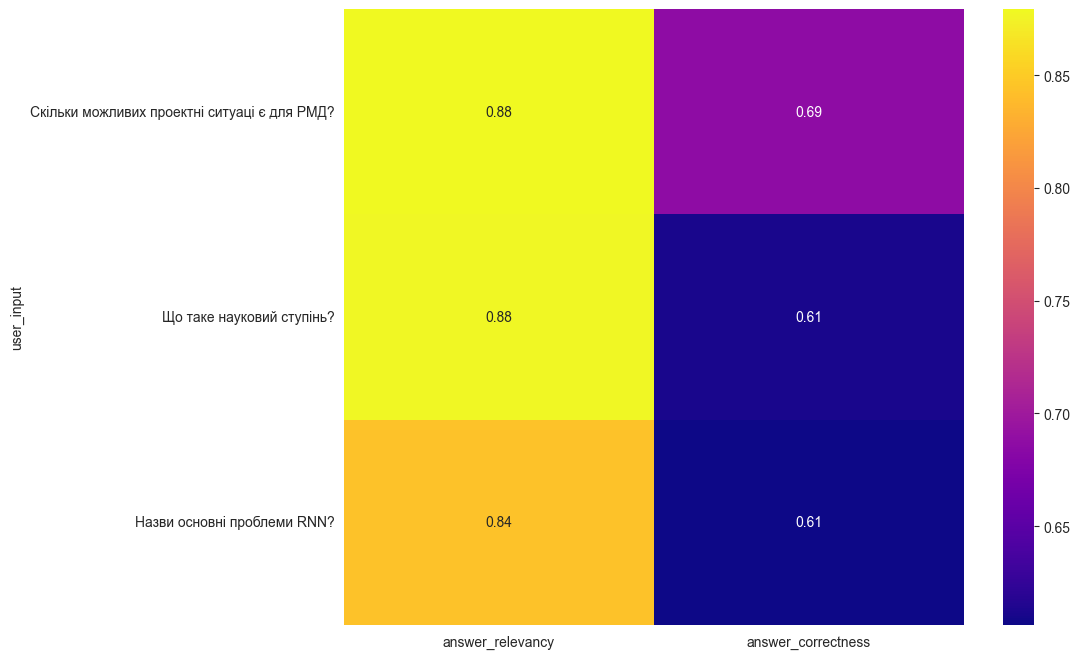

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(
    df.set_index("user_input")[["answer_relevancy", "answer_correctness"]],
    annot=True,
    cmap="plasma",
)
plt.show()

## Tests

- [First combintaion](#embedding-model-1-uaritmmultilingual_en_ru_uk)

In [8]:
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness
)
from langchain.chat_models import ChatOpenAI
from ragas.llms import LangchainLLMWrapper

In [14]:
def fine_tuning(embedding, kwargs_number, custom_prompt_template, chat_model_name):
    db_tuning = Chroma(
        persist_directory=CHROMA_PATH, # Local mode with in-memory storage only
        embedding_function=embedding,
        collection_name="rag")
    
    add_files(db_tuning)
    
    chat_model = ChatGroq(temperature=0,
                            model_name=f"{chat_model_name}",
                            api_key=groq_api_key)
    # налаштування chunk_size і overlap в функції split_documents()
    retriever = db_tuning.as_retriever(search_kwargs={'k': kwargs_number})
    
    prompt = PromptTemplate(template=custom_prompt_template,
                            input_variables=['context', 'question'])
    
    qa = RetrievalQA.from_chain_type(llm=chat_model,
                                   chain_type="stuff",
                                   retriever=retriever,
                                   return_source_documents=True,
                                   chain_type_kwargs={"prompt": prompt})
    
    # 1. 2 питання; 2. 3 питання; 3. 1 питання; 4. 3 питання; 5. 1 питання. 
    questions = ["Які документи потрібно надати заявнику при вступі до університету через Центр Крим – Донбас – Україна?",
                 "Які особливості вступної кампанії для осіб, які не мають документів державного зразка про освіту?",
                 "Які категорії студентів мають право на соціальну стипендію?",
                 "Як визначається ліміт стипендіатів на факультеті чи курсі?",
                 "Який порядок формування рейтингу успішності студентів?",
                 "На якій кафедрі викладає Донець Володимир Віталійович?",
                 "Що таке індивідуальна освітня траєкторія та як вона реалізується в Університеті?",
                 "Як визначається структура навчального року та що включає графік освітнього процесу?",
                 "Які форми здобуття вищої освіти передбачені в Університеті, і чим вони відрізняються між собою?",
                 "Перелік копій документів для оформлення соцстипендії"
                 ]
    references = ["Для вступу до університету через освітній центр «Крим – Донбас – Україна» заявник повинен подати комплект документів, які підтверджують його особу, освітній статус та право на пільгові умови вступу. Основним документом є заява на вступ, яка подається безпосередньо до університету через Центр. Разом із заявою вступник має пред’явити документ, що посвідчує особу, тобто паспорт або ID-картку, а за їх відсутності — свідоцтво про народження. Якщо документ про особу не містить відмітки про реєстрацію місця проживання на територіях, де неможливо забезпечити виконання стандартів освіти, факт проживання може бути підтверджено іншими офіційними документами, наприклад, довідкою про реєстрацію місця проживання батьків або документами, які містять відповідну адресу.Також подається документ державного зразка про повну загальну середню освіту разом із додатком до нього, якщо він є в наявності. У випадках, коли такого документа немає, вступник має надати довідку з освітнього закладу про форму та тривалість навчання, а також довідку про успішне проходження річного оцінювання і державної підсумкової атестації в рік вступу, яка фактично замінює атестат. Якщо вступник бажає, він може також подати сертифікати зовнішнього незалежного оцінювання або результати національного мультипредметного тесту попередніх років. Додатково можуть бути надані довідка про взяття на облік як внутрішньо переміщеної особи (якщо це актуально) і чотири кольорові фотокартки розміром 3×4 см.",
                  "Заявники, які не мають документа державного зразка про повну загальну середню освіту, можуть вступати до університету виключно через один освітній центр і подати до п’яти заяв. Для цього вони повинні пройти річне оцінювання та державну підсумкову атестацію, після чого отримати довідку про успішне завершення цих процедур. Саме ця довідка дає право вступати без сертифікатів ЗНО чи НМТ. Вступні іспити в такому разі включають українську мову, історію України, математику та ще один предмет на вибір. Якщо особа проходила річне оцінювання в центрі, результати з мови та історії можуть бути зараховані як вступні іспити. У разі неможливості особистого прибуття, вступна співбесіда також може проводитись дистанційно з відеофіксацією.",
                  "Соціальна стипендія призначається студентам, які не мають академічної заборгованості, показують задовільні результати навчання та включені до рейтингу успішності, за умови, що вони належать до передбачених законом пільгових категорій. Зокрема, це можуть бути діти-сироти, діти, позбавлені батьківського піклування, особи з їх числа, а також особи, які залишилися без батьків у віці від 18 до 23 років. Право на соціальну стипендію мають також студенти, які постраждали внаслідок Чорнобильської катастрофи, ті, хто має право на пільги згідно з законом про престижність шахтарської праці, а також діти учасників бойових дій, внутрішньо переміщені особи та інші категорії, визначені чинним законодавством. Усі ці підстави мають бути підтверджені відповідними документами.",
                  "Ліміт стипендіатів — це визначена частка студентів денної форми навчання, які мають право на академічну стипендію. Цей ліміт встановлюється Вченою радою університету перед кожним новим семестровим контролем і становить від 40 до 45 відсотків від кількості студентів, які навчаються за державним замовленням на певному факультеті, курсі або за конкретною спеціальністю. Ліміт може бути розширений у виключних випадках, наприклад, для студентів, які поновилися на навчання, ліквідували академічну заборгованість або повернулися з академічної відпустки. Існують також спеціальні ліміти: для першокурсників, для відмінників і для студентів природничих спеціальностей. Розрахунок лімітів базується на кількості студентів, затверджених обсягах фінансування та інших облікових показниках.",
                  "Рейтинг успішності студентів формується на основі їхніх навчальних досягнень за підсумками кожного семестрового контролю. До рейтингу включаються лише ті студенти, які навчаються за денною формою за державним замовленням і не мають академічної заборгованості, не повторювали складання іспитів для покращення оцінок, і мають повне навчальне навантаження відповідно до навчального плану. Для першокурсників, які ще не проходили семестрового контролю, рейтинг формується на основі конкурсного бала, з яким вони були зараховані до університету. Для всіх інших студентів рейтинговий бал обчислюється за спеціальною формулою, що враховує оцінки з дисциплін, практик, курсових робіт та інших форм підсумкового оцінювання, а також досягнення у науковій, громадській, технічній чи спортивній діяльності. Переважну вагу в рейтингу — 93% — має саме навчальна успішність. Зібрані дані передаються до Управління якості освіти факультетами та представниками студентського самоврядування, після чого формується повний рейтинг, на підставі якого стипендіальна комісія ухвалює рішення про призначення стипендій. Рейтинги оприлюднюються на сайті університету протягом трьох робочих днів після прийняття рішення.",
                  "Донець Володимир Віталійович викладає на кафедрі Математичного моделювання та аналізу даних",
                  "Індивідуальна освітня траєкторія в Харківському національному університеті імені В.Н. Каразіна визначається як персоналізований шлях здобувача освіти, який дає змогу розкрити його особистісний потенціал, ураховуючи здібності, інтереси, потреби, мотивацію, попередній досвід і можливості. Ця траєкторія ґрунтується на вільному виборі студентом змісту, темпу, форми й суб’єктів освітньої діяльності. Університет реалізує індивідуальні траєкторії через індивідуальний навчальний план, що формується у взаємодії між студентом і закладом освіти. План включає як обов’язкові дисципліни освітньої програми, так і ті, які студент обирає самостійно, використовуючи гарантовану можливість вибору не менше ніж 25 % навчального навантаження програми. Таким чином, університет підтримує самостійність студента у побудові власного освітнього шляху, надаючи йому широкий спектр варіативних дисциплін, викладачів і можливостей.",
                  "Навчальний рік в університеті триває дванадцять місяців, розпочинається, як правило, 1 вересня і складається з навчального часу, періодів підсумкового контролю, екзаменаційних сесій, а також вихідних, святкових і канікулярних днів. Основною моделлю організації освітнього процесу є двосеместрова система, хоча в окремих випадках може використовуватися триместрова. Один семестр зазвичай охоплює п’ять місяців — осінній триває з вересня до січня, весняний — з лютого до червня. Навчальний тиждень не перевищує 54 академічних години. Канікули встановлюються двічі на рік і мають загальну тривалість щонайменше вісім тижнів. Увесь рік структуровано відповідно до графіка освітнього процесу, який затверджується наказом ректора. Цей графік детально визначає всі ключові етапи навчального року: дати початку і завершення семестрів, час для навчальних занять, практик, стажувань, проведення сесій та канікул. Таким чином, університет забезпечує ритмічну і передбачувану організацію навчання, погоджену з навчальними планами та вимогами законодавства.",
                  "Університет передбачає кілька форм здобуття вищої освіти, які відповідають різним потребам і можливостям студентів. Серед них основною вважається інституційна форма, що включає денну (очну), вечірню, заочну, дистанційну та мережеву. Денна форма передбачає активну участь студента в усіх освітніх заходах із відривом від виробництва і є базовою моделлю навчання. Вечірня форма дозволяє поєднувати навчання з роботою, оскільки заняття проводяться переважно в позаробочий час. Заочна форма ґрунтується на самостійному опрацюванні матеріалу між короткотривалими сесіями, коли відбуваються заняття та контроль. Дистанційна форма передбачає навчання за допомогою електронних технологій у віртуальному середовищі, де викладач і студент можуть бути фізично віддаленими. Мережева форма дає можливість опановувати програму завдяки співпраці між різними освітніми установами, що спільно реалізують навчальний процес. Окремо виділяється дуальна форма, яка поєднує навчання з практичною діяльністю на підприємствах чи в установах. Ці форми можуть комбінуватися, що забезпечує гнучкість і доступність вищої освіти для різних категорій здобувачів.",
                  "У випадку, якщо студент подає документи на соціальну стипендію вперше, він має надати копії заяви, паспорта громадянина України разом із витягом з місця реєстрації, свідоцтва про народження (у разі необхідності), довідки про присвоєння реєстраційного номера облікової картки платника податків, документа, який підтверджує належність до пільгової категорії, а також студентського квитка, якщо він уже отриманий. Якщо студент вже отримував соціальну стипендію раніше й подає документи повторно, то в такому випадку достатньо подати нову заяву, копію студентського квитка, а також оновлений документ, який підтверджує пільгу — наприклад, якщо йдеться про довідку ВПО, то вона має бути чинною і датованою не раніше 2024 року. Звернення слід надсилати з темою листа «Соцстипендія». Важливо знати, що заяви приймаються протягом усього семестру, однак термін початку виплат безпосередньо залежить від дати подання документів."
                  ]
    answers = []
    contexts = []
    

    # Inference
    for query in questions:
        response = qa.invoke({"query": query})
        answers.append(response["result"])
        contexts.append([el.id for el in response["source_documents"]])
        # contexts.append([docs.page_content for docs in retriever.get_relevant_documents(query)])
    
    # To dict
    data = {
        "question": questions,
        "answer": answers,
        "contexts": contexts,
        "reference": references
    }
    
    print(data)
    # Convert dict to dataset
    dataset = Dataset.from_dict(data)
    
    llm = LangchainLLMWrapper(
        ChatOpenAI(
            model="openai/gpt-4o-mini",
            openai_api_key=openai_api_key,
            base_url="https://openrouter.ai/api/v1", 
        )
    )
    
    result = evaluate(
        dataset = dataset, 
        metrics=[
            context_precision,
            context_recall,
            faithfulness,
            answer_relevancy,
            answer_correctness,
        ],
        llm=llm,
        embeddings=embedding
    )
    print(result)
    df = result.to_pandas()
    print(df)
    return df
    
def show_plot_fine_tuning(df):
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        df.set_index("user_input")[["answer_relevancy", "answer_correctness", "context_precision", "context_recall", "context_recall"]],
        annot=True,
        cmap="plasma",
    )
    plt.show()

In [ ]:
embedding = HuggingFaceEmbeddings(model_name="uaritm/multilingual_en_ru_uk")

In [11]:
custom_prompt_template_1 = """You are a helpful assistant for students and faculty members. Your job is to answer questions as clearly, thoroughly, and accurately as possible, based only on the information provided in the university faculty documents.

Use the context below to provide a detailed and well-structured answer to the user's question. If the context contains multiple relevant facts, combine them into a comprehensive explanation. Feel free to include bullet points, numbered steps, or short sections for clarity.

If the answer is not found in the context, say:
**"The answer is not available in the provided faculty documents."**

Avoid speculation or making up answers.

Context:
---------
<b>{context}</b>
---------

Question:
<b>{question}</b>

Answer:

"""

custom_prompt_template_2 = """You are an intelligent assistant helping answer questions based on the provided documents.

Answer the question truthfully and accurately using only the information in the context below. If the answer is not explicitly stated in the context, say "The answer is not available in the provided documents."

Context:
---------
<b>{context}</b>
---------

Question:
<b>{question}</b>

Answer:"""

custom_prompt_template_3 = """You are an expert assistant that provides accurate, comprehensive, and well-structured answers to user questions based solely on the retrieved context provided below.

Your goal is to give the most <b>detailed and informative</b> response possible. Use all relevant parts of the context and combine insights from multiple sections if necessary. Include explanations, examples, lists, or clarifications to enhance understanding.

If possible, organize your response into <b>clearly labeled sections</b> or bullet points to improve clarity and readability.

⚠ Important:
- Do not use prior knowledge or assumptions.
- Do not hallucinate.
- If the answer cannot be found in the context, say:  
  <b>"The answer is not available in the provided documents."</b>
- ⚠ Provide the answer <b>exclusively in Ukrainian</b>. English may only be used for names, technical terms, or proper nouns that do not have a common Ukrainian equivalent.

Context:
---------
<b>{context}</b>
---------

Question:
<b>{question}</b>

Answer:"""

custom_prompt_template_4 = """Ти є експертним помічником, який надає точні, вичерпні та добре структуровані відповіді на запитання користувачів, базуючись виключно на наданому нижче контексті.

Твоя мета — надати якомога <b>детальнішу та інформативну</b> відповідь. Використовуй всі релевантні частини контексту та, за необхідності, поєднуй інформацію з різних розділів. Додай пояснення, приклади, списки або уточнення для кращого розуміння.

Якщо можливо, організуй свою відповідь у <b>чітко позначені розділи</b> або пункти, щоб поліпшити зрозумілість і читабельність.

⚠ Важливо:
- Не використовуй попередні знання або припущення.
- Не вигадуй/галюцінуй.
- Якщо відповідь не можна знайти в контексті, скажіть:  
  <b>«Відповідь відсутня в наданих документах».</b>
- ⚠ Надай відповідь <b>виключно українською мовою</b>. Англійська мова може використовуватися лише для імен, технічних термінів або власних назв, які не мають загальноприйнятого українського еквівалента.

Контекст:
---------
<b>{context}</b>
---------

Питання:
<b>{question}</b>
"""

In [37]:
df_custom_promt_1 = fine_tuning(embedding, 4, custom_prompt_template_1, "llama-3.3-70b-versatile")

break this process
break this process
break this process
break this process
break this process


 40%|████      | 2/5 [00:02<00:03,  1.18s/it]libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Number of existing documents in DB: 407
✅ No new documents to add
{'question': ['Які документи потрібно надати заявнику при вступі до університету через Центр Крим – Донбас – Україна?', 'Які особливості вступної кампанії для осіб, які не мають документів державного зразка про освіту?', 'Які категорії студентів мають право на соціальну стипендію?', 'Як визначається ліміт стипендіатів на факультеті чи курсі?', 'Який порядок формування рейтингу успішності студентів?', 'На якій кафедрі викладає Донець Володимир Віталійович?', 'Що таке індивідуальна освітня траєкторія та як вона реалізується в Університеті?', 'Як визначається структура навчального року та що включає графік освітнього процесу?', 'Які форми здобуття вищої освіти передбачені в Університеті, і чим вони відрізняються між собою?', 'Перелік копій документів для оформлення соцстипендії'], 'answer': ["Відповідно до пункту 2 розділу ІІ Порядку створення освітнього центру, заявником потрібно надати такі документи при вступі до універс

C:\Users\Ruslan\AppData\Local\Temp\ipykernel_8428\3941029694.py:71: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  ChatOpenAI(


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

{'context_precision': 0.9000, 'context_recall': 0.7875, 'faithfulness': 0.6148, 'answer_relevancy': 0.8001, 'answer_correctness': 0.4781}
                                          user_input  \
0  Які документи потрібно надати заявнику при вст...   
1  Які особливості вступної кампанії для осіб, як...   
2  Які категорії студентів мають право на соціаль...   
3  Як визначається ліміт стипендіатів на факульте...   
4  Який порядок формування рейтингу успішності ст...   
5  На якій кафедрі викладає Донець Володимир Віта...   
6  Що таке індивідуальна освітня траєкторія та як...   
7  Як визначається структура навчального року та ...   
8  Які форми здобуття вищої освіти передбачені в ...   
9  Перелік копій документів для оформлення соцсти...   

                                  retrieved_contexts  \
0  [data\parsed\dod9_2024[pdf].md:7, data\parsed\...   
1  [data\parsed\dod9_2024[pdf].md:7, data\parsed\...   
2  [data\parsed\stependia[pdf].md:19, data\parsed...   
3  [data\parsed\stepe

In [10]:
df_custom_promt_2 = fine_tuning(embedding, 4, custom_prompt_template_2, "llama-3.3-70b-versatile")

break this process
break this process
break this process
break this process
break this process


 40%|████      | 2/5 [00:16<00:20,  6.81s/it]libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
100%|██████████| 5/5 [00:17<00:00,  3.55s/it]


Number of existing documents in DB: 407
✅ No new documents to add
{'question': ['Які документи потрібно надати заявнику при вступі до університету через Центр Крим – Донбас – Україна?', 'Які особливості вступної кампанії для осіб, які не мають документів державного зразка про освіту?', 'Які категорії студентів мають право на соціальну стипендію?', 'Як визначається ліміт стипендіатів на факультеті чи курсі?', 'Який порядок формування рейтингу успішності студентів?', 'На якій кафедрі викладає Донець Володимир Віталійович?', 'Що таке індивідуальна освітня траєкторія та як вона реалізується в Університеті?', 'Як визначається структура навчального року та що включає графік освітнього процесу?', 'Які форми здобуття вищої освіти передбачені в Університеті, і чим вони відрізняються між собою?', 'Перелік копій документів для оформлення соцстипендії'], 'answer': ["Заявник повинен надати такі документи: заява на вступ до Університету через освітній центр «Крим – Донбас – Україна» та заяви на учас

C:\Users\Ruslan\AppData\Local\Temp\ipykernel_5624\3941029694.py:71: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  ChatOpenAI(


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

{'context_precision': 0.9000, 'context_recall': 0.7000, 'faithfulness': 0.2857, 'answer_relevancy': 0.6855, 'answer_correctness': 0.4852}
                                          user_input  \
0  Які документи потрібно надати заявнику при вст...   
1  Які особливості вступної кампанії для осіб, як...   
2  Які категорії студентів мають право на соціаль...   
3  Як визначається ліміт стипендіатів на факульте...   
4  Який порядок формування рейтингу успішності ст...   
5  На якій кафедрі викладає Донець Володимир Віта...   
6  Що таке індивідуальна освітня траєкторія та як...   
7  Як визначається структура навчального року та ...   
8  Які форми здобуття вищої освіти передбачені в ...   
9  Перелік копій документів для оформлення соцсти...   

                                  retrieved_contexts  \
0  [data\parsed\dod9_2024[pdf].md:7, data\parsed\...   
1  [data\parsed\dod9_2024[pdf].md:7, data\parsed\...   
2  [data\parsed\stependia[pdf].md:19, data\parsed...   
3  [data\parsed\stepe

In [11]:
df_custom_promt_3 = fine_tuning(embedding, 4, custom_prompt_template_3, "llama-3.3-70b-versatile")

break this process
break this process
break this process
break this process
break this process


 40%|████      | 2/5 [00:00<00:00,  3.23it/s]libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


Number of existing documents in DB: 407
✅ No new documents to add
{'question': ['Які документи потрібно надати заявнику при вступі до університету через Центр Крим – Донбас – Україна?', 'Які особливості вступної кампанії для осіб, які не мають документів державного зразка про освіту?', 'Які категорії студентів мають право на соціальну стипендію?', 'Як визначається ліміт стипендіатів на факультеті чи курсі?', 'Який порядок формування рейтингу успішності студентів?', 'На якій кафедрі викладає Донець Володимир Віталійович?', 'Що таке індивідуальна освітня траєкторія та як вона реалізується в Університеті?', 'Як визначається структура навчального року та що включає графік освітнього процесу?', 'Які форми здобуття вищої освіти передбачені в Університеті, і чим вони відрізняються між собою?', 'Перелік копій документів для оформлення соцстипендії'], 'answer': ['**Документи, необхідні для вступу до університету через Центр Крим – Донбас – Україна**\n\nПри вступі до університету через Центр Кри

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

{'context_precision': 0.9000, 'context_recall': 0.7000, 'faithfulness': 0.6066, 'answer_relevancy': 0.8170, 'answer_correctness': 0.5640}
                                          user_input  \
0  Які документи потрібно надати заявнику при вст...   
1  Які особливості вступної кампанії для осіб, як...   
2  Які категорії студентів мають право на соціаль...   
3  Як визначається ліміт стипендіатів на факульте...   
4  Який порядок формування рейтингу успішності ст...   
5  На якій кафедрі викладає Донець Володимир Віта...   
6  Що таке індивідуальна освітня траєкторія та як...   
7  Як визначається структура навчального року та ...   
8  Які форми здобуття вищої освіти передбачені в ...   
9  Перелік копій документів для оформлення соцсти...   

                                  retrieved_contexts  \
0  [data\parsed\dod9_2024[pdf].md:7, data\parsed\...   
1  [data\parsed\dod9_2024[pdf].md:7, data\parsed\...   
2  [data\parsed\stependia[pdf].md:19, data\parsed...   
3  [data\parsed\stepe

In [18]:
df_custom_promt_4 = fine_tuning(embedding, 4, custom_prompt_template_4, "llama-3.3-70b-versatile")

break this process
break this process
break this process
break this process
break this process


100%|██████████| 5/5 [00:20<00:00,  4.09s/it]


Number of existing documents in DB: 407
✅ No new documents to add
{'question': ['Які документи потрібно надати заявнику при вступі до університету через Центр Крим – Донбас – Україна?', 'Які особливості вступної кампанії для осіб, які не мають документів державного зразка про освіту?', 'Які категорії студентів мають право на соціальну стипендію?', 'Як визначається ліміт стипендіатів на факультеті чи курсі?', 'Який порядок формування рейтингу успішності студентів?', 'На якій кафедрі викладає Донець Володимир Віталійович?', 'Що таке індивідуальна освітня траєкторія та як вона реалізується в Університеті?', 'Як визначається структура навчального року та що включає графік освітнього процесу?', 'Які форми здобуття вищої освіти передбачені в Університеті, і чим вони відрізняються між собою?', 'Перелік копій документів для оформлення соцстипендії'], 'answer': ["**Документи, необхідні для вступу до університету через Центр Крим – Донбас – Україна**\n\nПри вступі до університету через Центр Кри

C:\Users\Ruslan\AppData\Local\Temp\ipykernel_13580\3941029694.py:71: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  ChatOpenAI(


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

{'context_precision': 0.9000, 'context_recall': 0.7750, 'faithfulness': 0.4927, 'answer_relevancy': 0.6249, 'answer_correctness': 0.4415}
                                          user_input  \
0  Які документи потрібно надати заявнику при вст...   
1  Які особливості вступної кампанії для осіб, як...   
2  Які категорії студентів мають право на соціаль...   
3  Як визначається ліміт стипендіатів на факульте...   
4  Який порядок формування рейтингу успішності ст...   
5  На якій кафедрі викладає Донець Володимир Віта...   
6  Що таке індивідуальна освітня траєкторія та як...   
7  Як визначається структура навчального року та ...   
8  Які форми здобуття вищої освіти передбачені в ...   
9  Перелік копій документів для оформлення соцсти...   

                                  retrieved_contexts  \
0  [data\parsed\dod9_2024[pdf].md:7, data\parsed\...   
1  [data\parsed\dod9_2024[pdf].md:7, data\parsed\...   
2  [data\parsed\stependia[pdf].md:19, data\parsed...   
3  [data\parsed\stepe

In [ ]:
# the best prompt is # 3
# сравнение графиков по показателям 

In [ ]:
# chunk_size = 1000 __ overlap = 150 __ kwargs_number = 4
df_chunks_1 = fine_tuning(embedding, 4, custom_prompt_template_3, "llama-3.3-70b-versatile")

In [ ]:
# chunk_size = 1400 __ overlap = 200 __ kwargs_number = 5
df_chunks_2 = fine_tuning(embedding, 5, custom_prompt_template_3, "llama-3.3-70b-versatile")

In [ ]:
# chunk_size = 600 __ overlap = 100 __ kwargs_number = 4
df_chunks_3 = fine_tuning(embedding, 4, custom_prompt_template_3, "llama-3.3-70b-versatile")

In [ ]:
# the best chunk tuning is # 1 
# сравнение графиков по показателям 

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import textwrap

In [27]:
questions = [
        "Які документи потрібно надати заявнику при вступі до університету через Центр Крим – Донбас – Україна?",
        "Які особливості вступної кампанії для осіб, які не мають документів державного зразка про освіту?",
        "Які категорії студентів мають право на соціальну стипендію?",
        "Як визначається ліміт стипендіатів на факультеті чи курсі?",
        "Який порядок формування рейтингу успішності студентів?",
        "На якій кафедрі викладає Донець Володимир Віталійович?",
        "Що таке індивідуальна освітня траєкторія та як вона реалізується в Університеті?",
        "Як визначається структура навчального року та що включає графік освітнього процесу?",
        "Які форми здобуття вищої освіти передбачені в Університеті, і чим вони відрізняються між собою?",
        "Перелік копій документів для оформлення соцстипендії",
        "Середнє значення"
]

precision_prompts = pd.DataFrame({
    'questions': questions,
    'prompt_1':[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.9000],
    'prompt_2':[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0,  0.9000],
    'prompt_3':[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.9000],
    'prompt_4':[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.9000],
})

recall_prompts = pd.DataFrame({
    'questions': questions,
    'prompt_1':[1.000, 1.000, 1.000, 0.000, 1.000, 0.000, 1.000, 0.875, 1.000, 1.000, 0.7875],
    'prompt_2':[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.7000],
    'prompt_3':[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0,  0.7000],
    'prompt_4':[1.00, 1.00, 1.00, 0.00, 1.00, 0.00, 1.00, 0.75, 1.00, 1.00, 0.7750],
})

faithfulness_prompts = pd.DataFrame({
    'questions': questions,
    'prompt_1':[0.666667, 0.636364, 1.000000, 0.947368, 0.350000, 0.666667, 1.000000, 0.347826, 0.533333, 0.000000,  0.6148],
    'prompt_2':[0.375000, 0.000000, 0.166667, 0.666667, 0.125000, 0.000000, 1.000000, 0.523810, 0.000000, 0.000000, 0.2857],
    'prompt_3':[0.666667, 0.428571, 0.444444, 0.153846, 1.000000, 0.600000, 1.000000, 0.607143, 0.880000, 0.285714,  0.6066],
    'prompt_4':[0.444444, 0.000000, 0.000000, 0.857143, 0.933333, 0.000000, 1.000000, 0.567568, 1.000000, 0.125000, 0.4927],
})

relevancy_prompts = pd.DataFrame({
    'questions': questions,
    'prompt_1':[0.912797, 0.924102, 0.876377, 1.000000, 0.931876, 0.000000, 0.883272, 0.808850, 0.935054, 0.728257, 0.8001],
    'prompt_2':[0.917670, 0.686314, 0.878188, 1.000000, 0.971713, 0.000000, 0.819030, 0.873421, 0.000000, 0.708295, 0.6855],
    'prompt_3':[0.933007, 0.927971, 0.897190, 1.000000, 0.888835, 0.000000, 0.937177, 0.931598, 0.925755, 0.728257, 0.8170],
    'prompt_4':[0.000000, 0.959980, 0.882508, 0.853730, 0.971713, 0.000000, 0.937177, 0.915366, 0.000000, 0.728257,  0.6249],
})

correctness_prompts = pd.DataFrame({
    'questions': questions,
    'prompt_1':[0.373494, 0.515297, 0.754758, 0.352978, 0.760073, 0.147947, 0.595106, 0.467884, 0.388837, 0.424152, 0.4781],
    'prompt_2':[0.530283, 0.684847, 0.662810, 0.360619, 0.583808, 0.041778, 0.798661, 0.763373, 0.003230, 0.422942, 0.4852],
    'prompt_3':[0.350866, 0.385633, 0.801333, 0.571802, 0.710814, 0.144460, 0.605434, 0.767545, 0.719867, 0.581905, 0.5640],
    'prompt_4':[0.327541, 0.372131, 0.624017, 0.460802, 0.734118, 0.024626, 0.554828, 0.736649, -0.003383, 0.583325, 0.4415],
})


precision_chunk = pd.DataFrame({
    'questions': questions,
    'chunk_1':[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.9000],
    'chunk_2':[1.0, 1.0, 1.0, None, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.8889],
    'chunk_3':[1.0, 1.0, 1.0, 1.0, None, 0.0, 1.0, 1.0, 1.0, 1.0, 0.8889],
})

recall_chunk = pd.DataFrame({
    'questions': questions,
    'chunk_1':[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0,  0.7000],
    'chunk_2':[1.000000, 1.000000, 1.000000, 0.000000, 1.000000, 0.000000, 1.000000, 0.625000, 0.222222, 1.000000, 0.6847],
    'chunk_3':[1.00, 1.00, 1.00, 0.00, 1.00, 0.00, 1.00, 0.75, 1.00, 1.00, 0.7750],
})

faithfulness_chunk = pd.DataFrame({
    'questions': questions,
    'chunk_1':[0.666667, 0.428571, 0.444444, 0.153846, 1.000000, 0.600000, 1.000000, 0.607143, 0.880000, 0.285714,  0.6066],
    'chunk_2':[0.277778, 0.000000, 0.000000, 0.000000, 0.833333, 0.000000, 1.000000, 0.735294, 0.931034, 0.750000, 0.4527],
    'chunk_3':[0.941176, 0.500000, 0.000000, 0.500000, 0.500000, 0.750000, 1.000000, 0.772727, 0.333333, 0.000000,  0.5297],
})

relevancy_chunk = pd.DataFrame({
    'questions': questions,
    'chunk_1':[0.933007, 0.927971, 0.897190, 1.000000, 0.888835, 0.000000, 0.937177, 0.931598, 0.925755, 0.728257, 0.8170],
    'chunk_2':[0.930763, 0.948020, 0.698766, 0.917301, 0.888835, 0.000000, 0.930271, 0.939345, 0.907726, 0.000000, 0.7161],
    'chunk_3':[0.933007, 0.929934, 0.732041, 1.000000, 0.888835, 0.000000, 0.930271, 0.920300, 0.907726, 0.728257, 0.7970],
})

correctness_chunk = pd.DataFrame({
    'questions': questions,
    'chunk_1':[0.350866, 0.385633, 0.801333, 0.571802, 0.710814, 0.144460, 0.605434, 0.767545, 0.719867, 0.581905, 0.5640],
    'chunk_2':[0.427316, 0.427064, 0.486270, 0.385899, 0.562590, 0.050481, 0.605434, 0.835567, 0.598751, 0.156884,  0.4536],
    'chunk_3':[0.419084, 0.375397, 0.773120, 0.338294, 0.967437, 0.114769, 0.452725, 0.535970, 0.561233, 0.970757, 0.5509],
})

In [20]:
def draw_plt(df, is_prompt):
    plt.figure(figsize=(10, 8))
    sns.heatmap(
         df.set_index("questions")[["prompt_1", "prompt_2", "prompt_3", "prompt_4"]] if is_prompt else df.set_index("questions")[["chunk_1", "chunk_2", "chunk_3",]],
        annot=True,
        cmap="plasma",
        yticklabels=df["questions"].apply(lambda x: textwrap.fill(x, width=40))
    )
    
    plt.ylabel("Питання")
    plt.show()

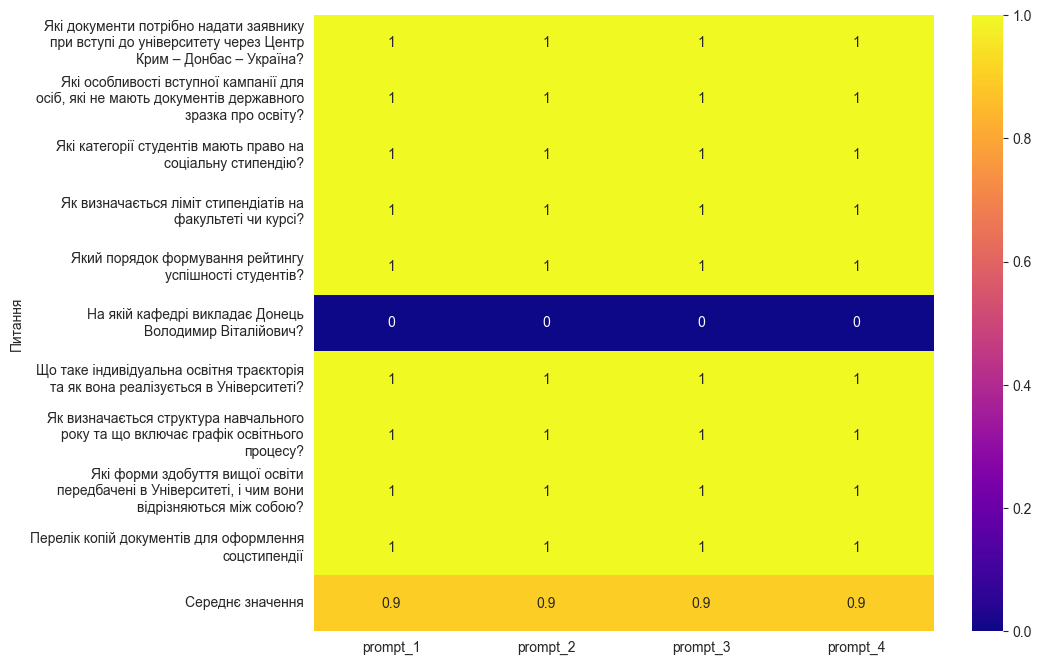

In [21]:
draw_plt(precision_prompts, True)

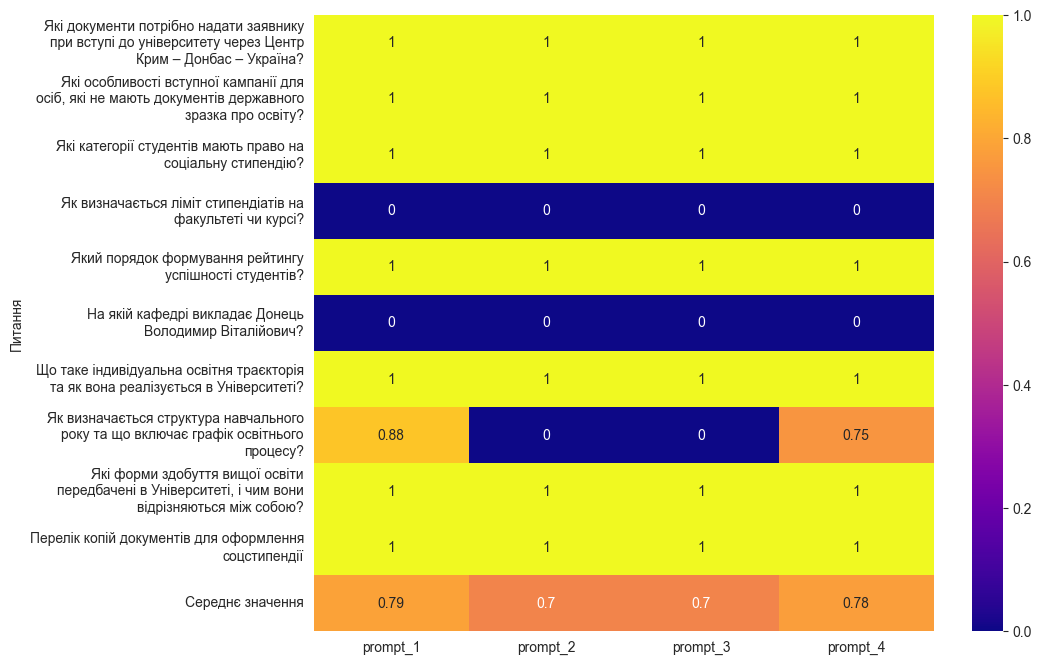

In [22]:
draw_plt(recall_prompts, True)

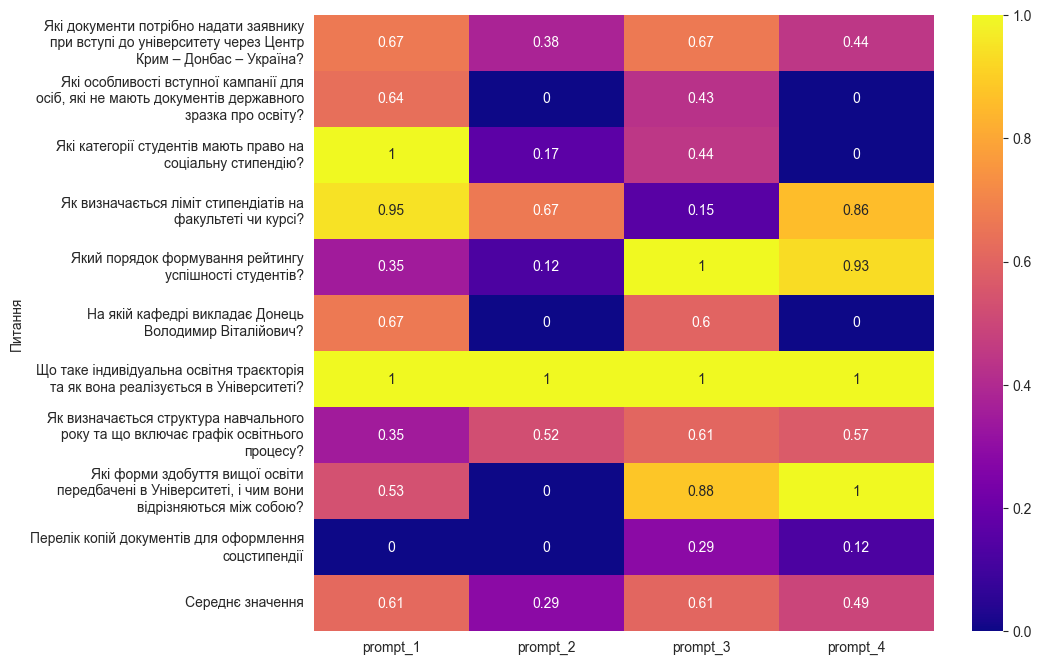

In [23]:
draw_plt(faithfulness_prompts, True)

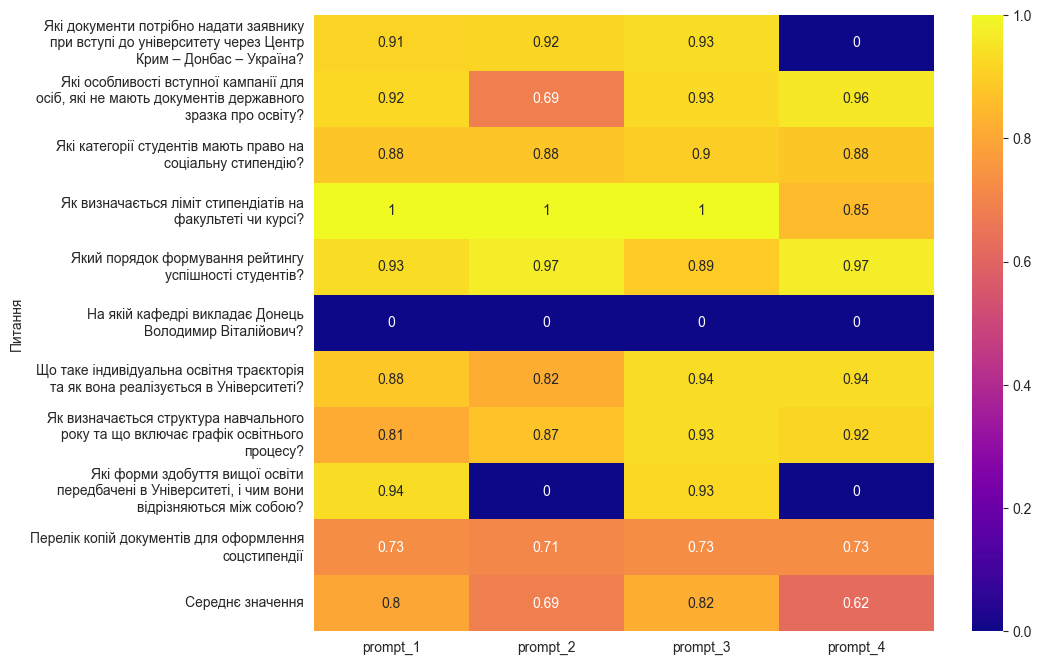

In [24]:
draw_plt(relevancy_prompts, True)

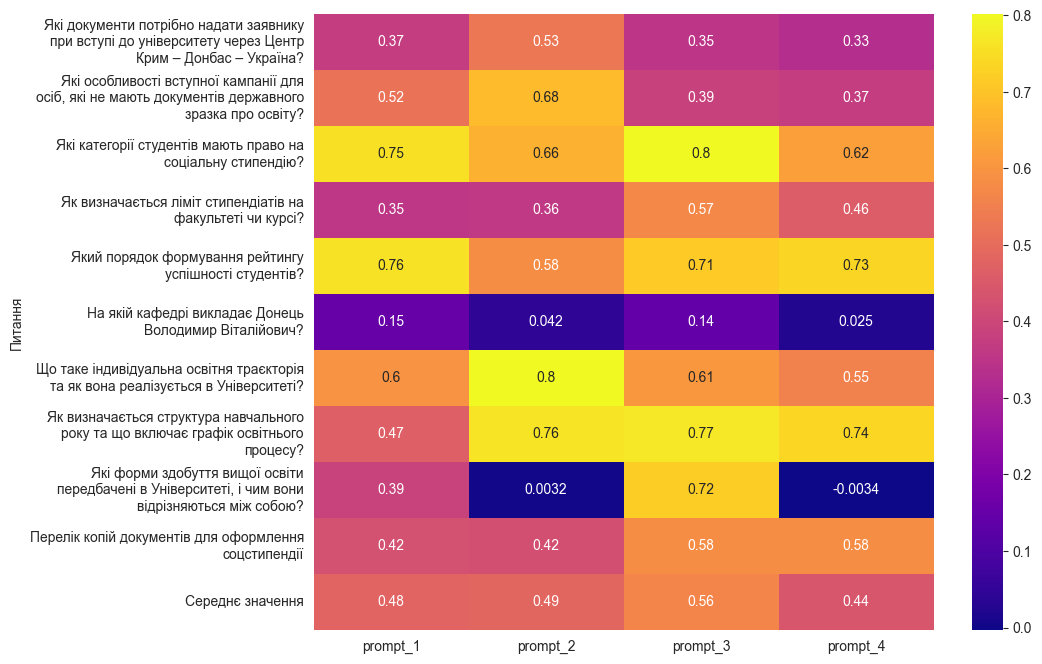

In [25]:
draw_plt(correctness_prompts, True)

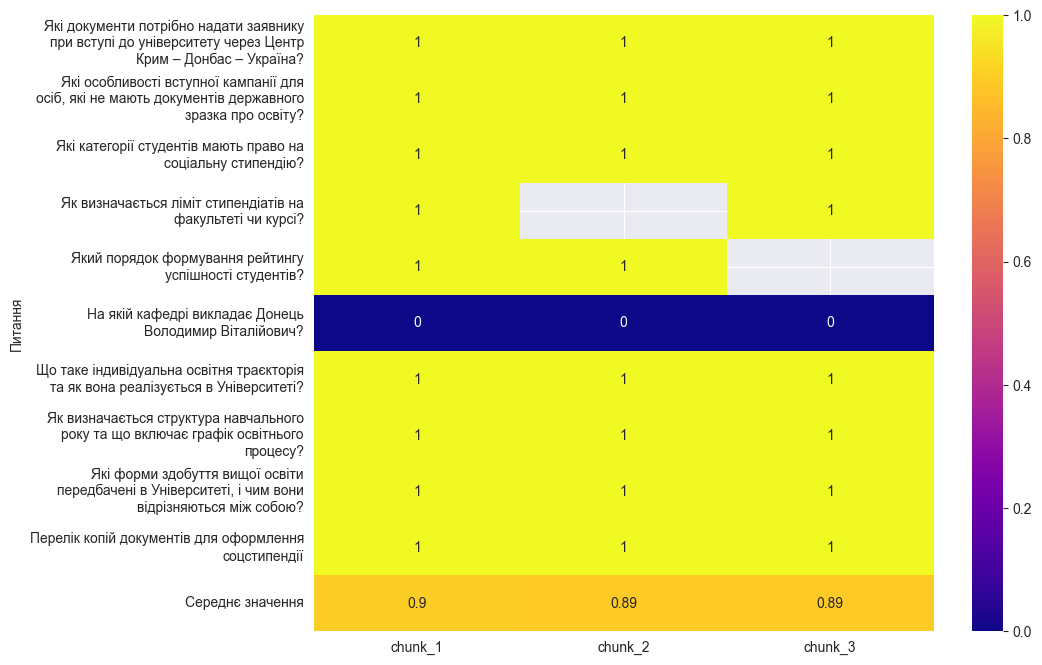

In [28]:
draw_plt(precision_chunk, False)

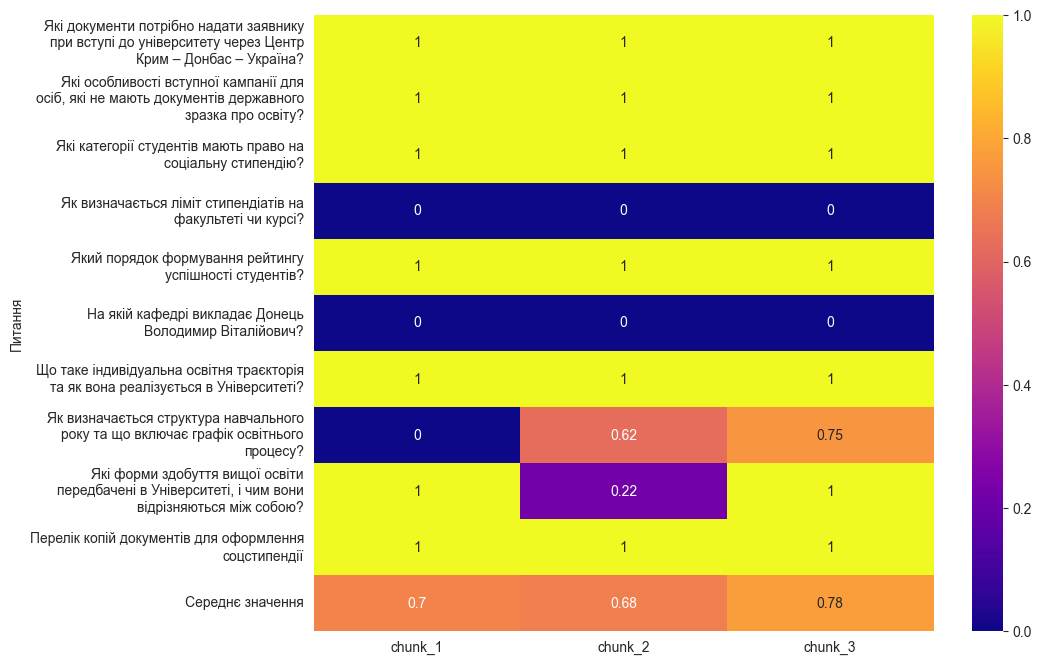

In [29]:
draw_plt(recall_chunk, False)

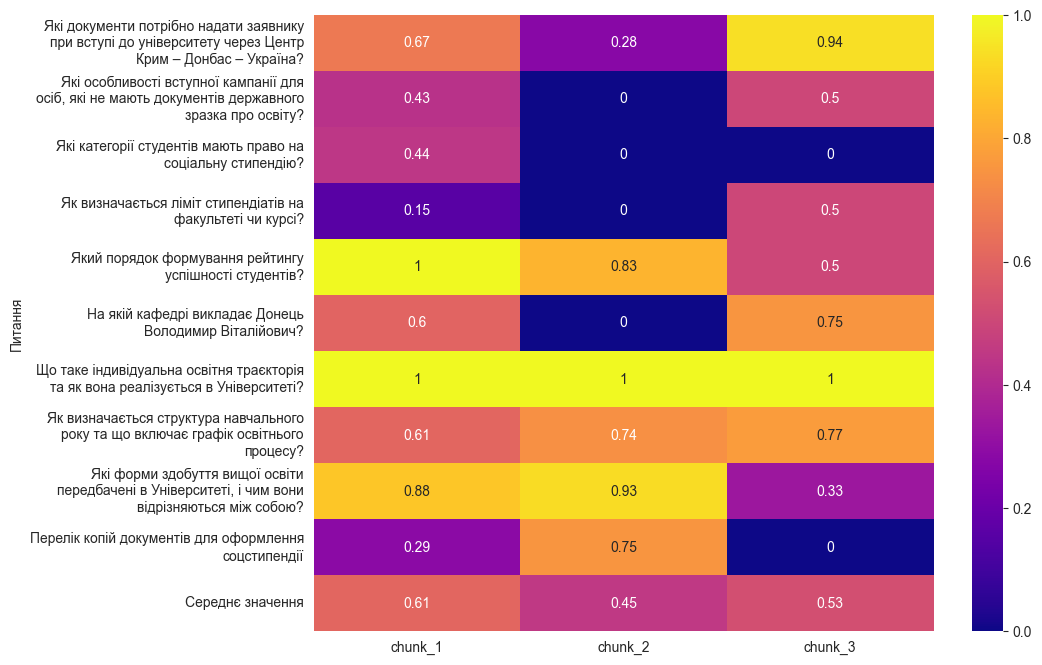

In [30]:
draw_plt(faithfulness_chunk, False)

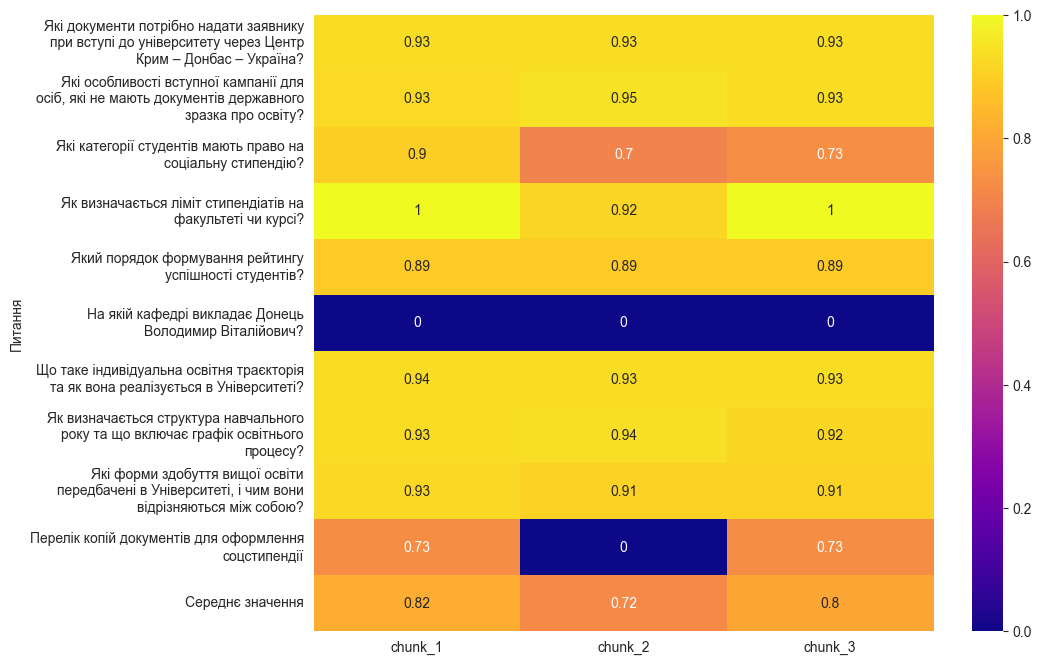

In [31]:
draw_plt(relevancy_chunk, False)

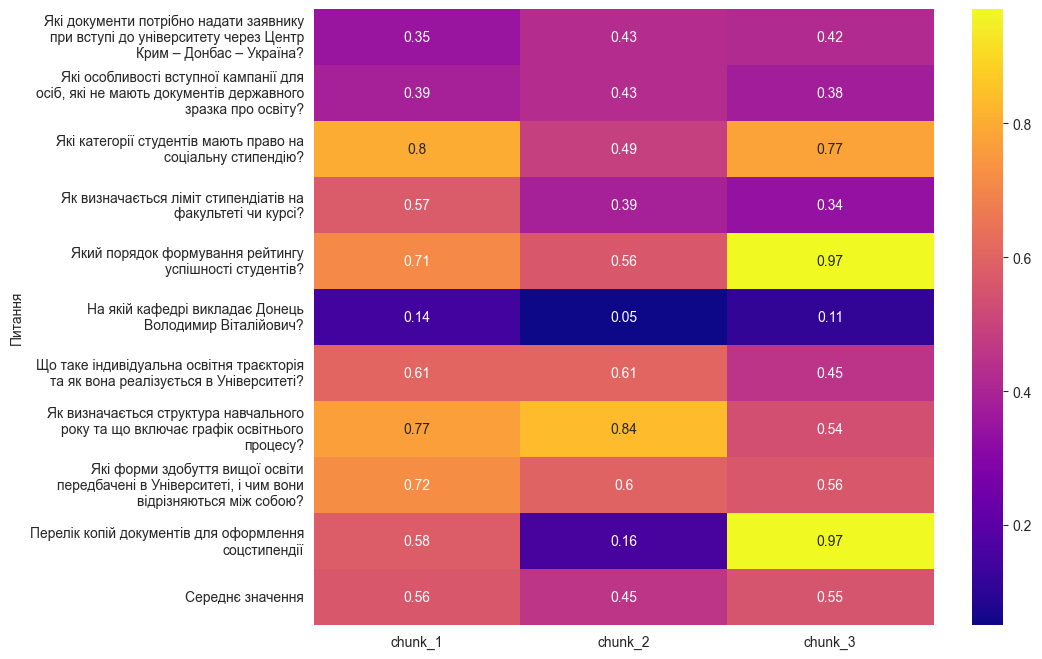

In [32]:
draw_plt(correctness_chunk, False)